**Digital Epidemiology Project**
#**Sentiment Analysis of Drug Reviews**

Name: ***Mohanraj Chandrasekar***

Matricola:**1921450**


###**Imports**

In [19]:
!pip install --upgrade nltk

     |████████████████████████████████| 1.4MB 7.7MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434676 sha256=682636da1f24340985b2015d7c7222cc1a03282cec8cc51b5bfbf2dfd51155e3
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [1]:
from google.colab import drive
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.metrics import roc_curve, auc,roc_auc_score
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
import scikitplot as skplt

In [12]:
from itertools import cycle
from keras.preprocessing.text import Tokenizer

Mounting Drive for Dataset fetching

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


###**Loading Dataset**

In [56]:
trainrdata = pd.read_csv ("drive/MyDrive/r_data/drugsComTrain_raw.tsv", sep = '\t')
testrdata = pd.read_csv ("drive/MyDrive/r_data/drugsComTest_raw.tsv", sep = '\t')
trainrdata.rename(columns={'Unnamed: 0':'UniqueID'}, inplace=True)
testrdata.rename(columns={'Unnamed: 0':'UniqueID'}, inplace=True)

In [57]:
trainrdata.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [58]:
testrdata.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [59]:
print("The shape of train and set dataset given:")
len(trainrdata),len(testrdata)

The shape of train and set dataset given:


(161297, 53766)

###**Pre Processing Data**

In [76]:
#Merging Dataset to perform EDA and Feature Engineering
data = pd.concat([trainrdata,testrdata])
data.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [77]:
print("The size of the Dataset",data.shape)

The size of the Dataset (215063, 7)


In [78]:
data.dtypes

UniqueID         int64
drugName        object
condition       object
review          object
rating         float64
date            object
usefulCount      int64
dtype: object

In [79]:
#changing datatype of rating into integer for processing further
data['rating'] = data['rating'].astype(int)

In [80]:
#changing datatype of date into appropriate datetime format
data['date'] = pd.to_datetime(data['date'])

In [81]:
# Separating the day, month and year from the Date
data['year'] = data['date'].apply(lambda x: x.year)
data['month'] = data['date'].apply(lambda x: x.month)

###**Missing Data**

In [82]:
data.isna().sum()

UniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
year              0
month             0
dtype: int64

In [83]:
print("Percentage of Missing values:",(data['condition'].isna().sum()/len(data))*100)

Percentage of Missing values: 0.5551861547546533


Since the percentage of missing value is 0.55% , the following rows of missing values going to be deleted from the dataset using dropna function.

In [84]:
data =data.dropna(how = 'any', axis = 0)
data.sort_values(['UniqueID'], ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [85]:
data.isna().sum()

UniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
year           0
month          0
dtype: int64

In [86]:
print("The length of the final dataset after removing null values:",len(data))

The length of the final dataset after removing null values: 213869


In [87]:
data.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount,year,month
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,2015,10
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,2015,10
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,2015,10
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,2015,10
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,2015,10


In [88]:
#storing data in a separate file for processing further without need of doing the above procedure again
data.to_csv('drive/MyDrive/r_data/drugs.csv',index=False)

In [89]:
#reading dataset from the file
d = pd.read_csv('drive/MyDrive/r_data/drugs.csv')

In [90]:
len(d)

213869

In [91]:
d.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount,year,month
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,2015,10
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,2015,10
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,2015,10
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,2015,10
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,2015,10


###**Exploratory Data Analysis**

The top drugs which has most positive rating 10/10

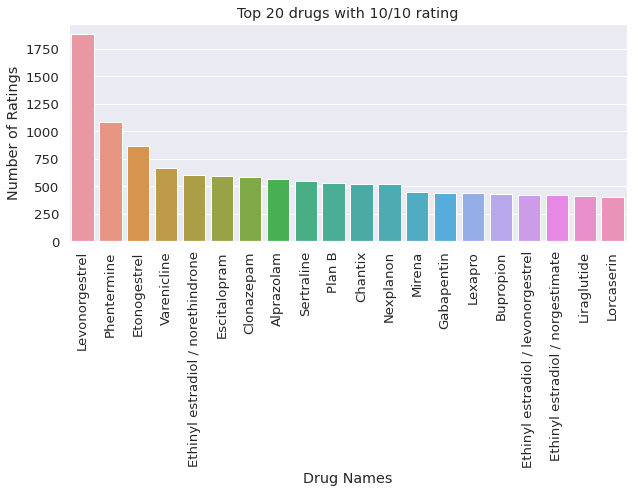

In [102]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

rating = dict(d.loc[d.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);


The top 20 drugs which has the least rating 1/10



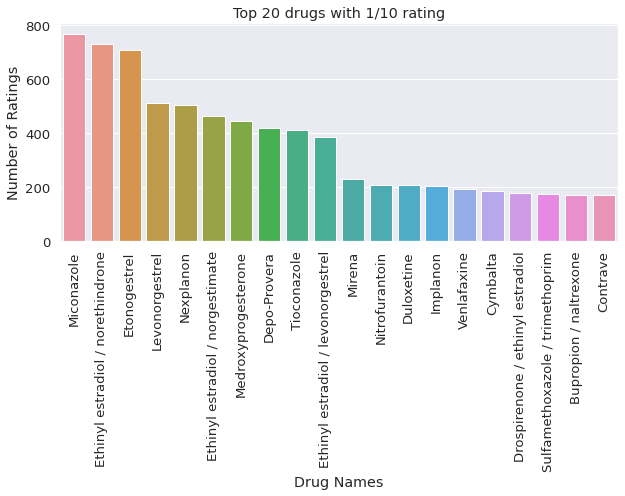

In [103]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

rating = dict(d.loc[d.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

The top 10 condition that people are using drugs and reviews present

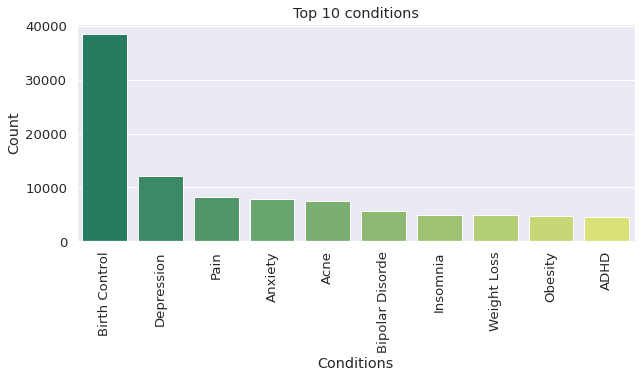

In [108]:
condition = dict(d['condition'].value_counts())
topc = list(condition.keys())[0:10]
valuec = list(condition.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.2)
plt.rcParams['figure.figsize'] = [10,4]

sns_ = sns.barplot(x = topc, y = valuec, palette = 'summer')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

plt.setp(sns_.get_xticklabels(), rotation=90);

As we can see above is top condition that people are using drug is Birth Control so we are going to analyse the condition below

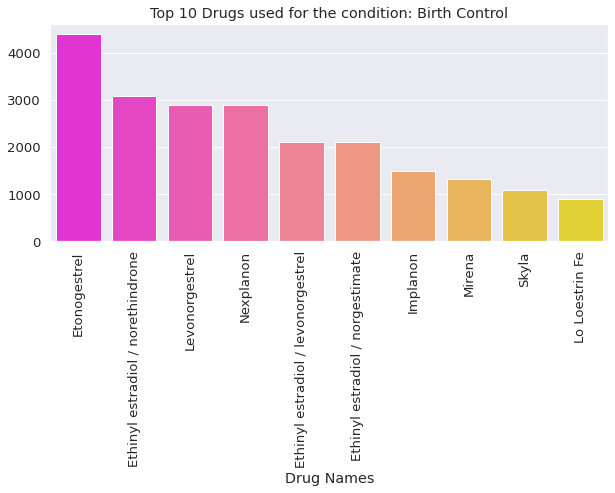

In [111]:
new = d[d['condition'] == 'Birth Control']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

snsbc = sns.barplot(x = new.index, y = new.values, palette = 'spring')
snsbc.set_xlabel('Drug Names')
snsbc.set_title("Top 10 Drugs used for the condition: Birth Control")
plt.setp(snsbc.get_xticklabels(), rotation = 90);

The number of reviews for each year

Text(0.5, 1.0, 'Number of reviews against date')

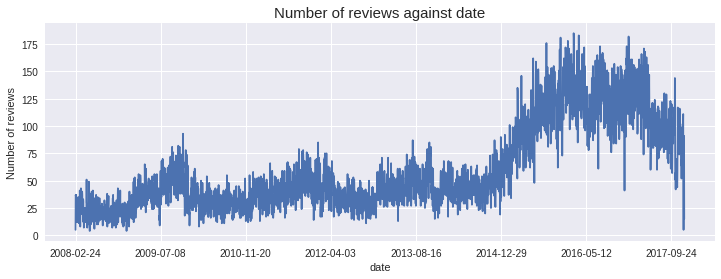

In [118]:
d.groupby('date')['review'].size().plot(figsize=(12,4))
plt.ylabel('Number of reviews')
plt.title("Number of reviews against date",fontsize=15)

Average Rating calculated on the basis of months

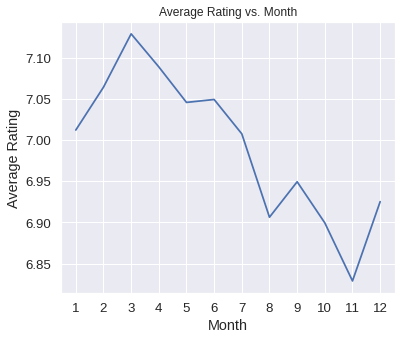

In [116]:
#Monthly rating feature
fig, ax = plt.subplots(1,1, figsize=(6,5))

plt.style.use('seaborn')

ax.plot(d.groupby('month').rating.mean())
ax.set_ylabel('Average Rating')
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))
ax.set_title('Average Rating vs. Month')

plt.show()

The number of reviews having rating class of 1 to 10

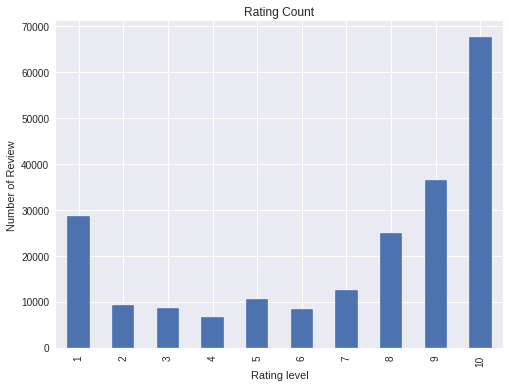

In [122]:
fig = plt.figure(figsize=(8,6))
d.groupby('rating').review.count().plot.bar(ylim=0)
plt.xlabel('Rating level')
plt.ylabel('Number of Review')
plt.title("Rating Count")
plt.show()

###**Sentiment Analysis**


The three classes of sentiment is classified based on the ratings given by user

0 Negative  @rating level 1-4

1 Neutral   @rating level 5-6

2 Positive  @rating level 7-10

In [124]:
#the sentiment classification is done by categorizing into three classes of sentiment
def classify(r):
  if r<=4:
    return 0
  elif r>=7:
    return 2
  else:
    return 1

In [125]:
d['sentiment'] = d['rating'].apply(classify)

####Checkpoint

In [128]:
#storing data in a separate file for processing further without need of doing the above procedure again
d.to_csv('drive/MyDrive/r_data/review.csv',index=False)

In [2]:
data = pd.read_csv('drive/MyDrive/r_data/review.csv')

In [3]:
data.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount,year,month,sentiment
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,2015,10,0
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,2015,10,2
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,2015,10,2
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,2015,10,2
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,2015,10,0


The sentiment distribution over dataset

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'negative       neutral        positive')

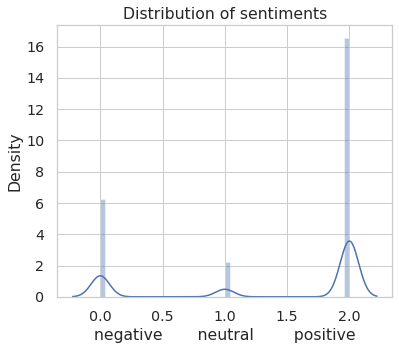

In [188]:
sns_2 = sns.distplot(data['sentiment'])

sns_2.set_title('Distribution of sentiments')
sns_2.set_xlabel("negative       neutral        positive")

As we can see above the sentiment has normal distribution and we can observe that the most present sentiment are positive, negative and neutral respectively

The following analyse the pie chart of the sentiments across the review

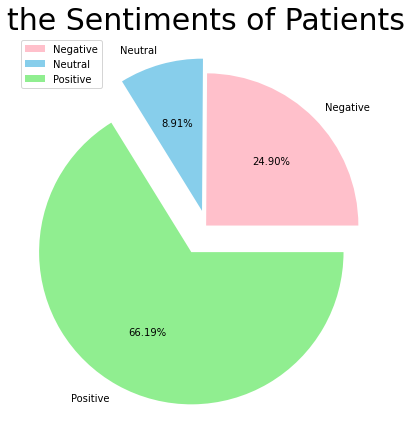

In [7]:
size = [53256, 19053,141560]
colors = ['pink', 'skyblue','lightgreen']
labels = "Negative","Neutral","Positive"
explode = [0, 0.1,0.2]

plt.rcParams['figure.figsize'] = (7,7)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('the Sentiments of Patients', fontsize = 30)
plt.legend()
plt.show()

###**Feature Engineering**

The words cloud of reviews with the rating of 10

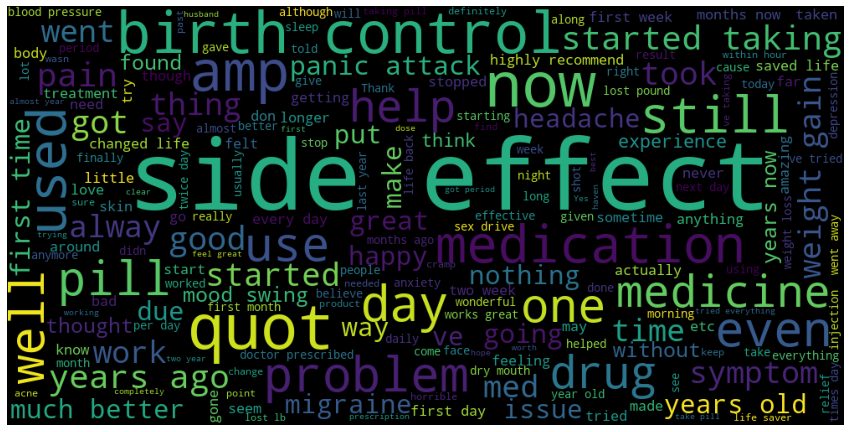

In [191]:
ten = data.loc[data.rating == 10, 'review']
k = (' '.join(ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

the worlds cloud of reviews with rating 1 which is least

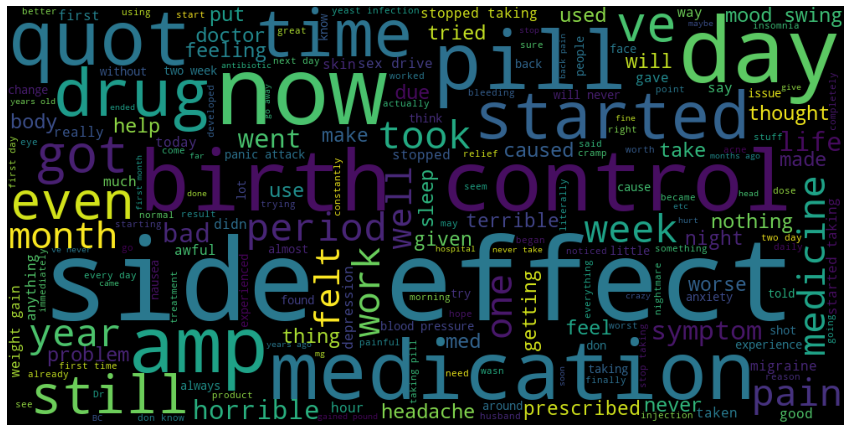

In [192]:
one =data.loc[data.rating == 1, 'review']
k1 = (' '.join(one))

wordcloud = WordCloud(width = 1000, height = 500).generate(k1)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

Cleaning the Review Text
such as white space, special characters etc.



In [3]:
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [4]:
data['review_clean'] = review_clean(data['review'])

In [7]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# Removing the stopwords
stop_words = set(stopwords.words('english'))
data['review_clean'] = data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [10]:
data.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount,year,month,sentiment,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,2015,10,0,depo injection since january 2015 bleeding sto...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,2015,10,2,im 21 years old recently found might pcos have...
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,2015,10,2,shot 11 years month ago never 1 period even sp...
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,2015,10,2,ive four shots point birth control pills years...
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,2015,10,0,total 3 shots got first one leaving hospital g...


Adding additional features in order to improvise model

In [11]:
#Word count in each review
data['word_count']=data["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count 
data['unique_count']=data["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
data['letters']=data["review_clean"].apply(lambda x: len(str(x)))
#stop words count
data["stopwords_count"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))


####Check Point

In [13]:

#storing data in a separate file for processing further without need of doing the above procedure again
data.to_csv('drive/MyDrive/r_data/feature.csv',index=False)

In [21]:
data = pd.read_csv('drive/MyDrive/r_data/feature.csv')

In [15]:
data.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount,year,month,sentiment,review_clean,word_count,unique_count,letters,stopwords_count
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,2015,10,0,depo injection since january 2015 bleeding sto...,52,46,364,45
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,2015,10,2,im 21 years old recently found might pcos have...,63,53,401,39
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,2015,10,2,shot 11 years month ago never 1 period even sp...,30,25,166,28
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,2015,10,2,ive four shots point birth control pills years...,70,56,443,74
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,2015,10,0,total 3 shots got first one leaving hospital g...,70,64,436,79


The correlation heatmap of the features to select the features

In [52]:
df =data.copy()

In [56]:
# Label Encoding Drugname and Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['drugName', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    df[feature] = label_encoder_feat[feature].fit_transform(df[feature])

In [53]:
def sentiment(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

In [55]:
df['sentiment_rate'] = sentiment(df['review'])
df['sentiment_rate_clean']=sentiment(df['review'])

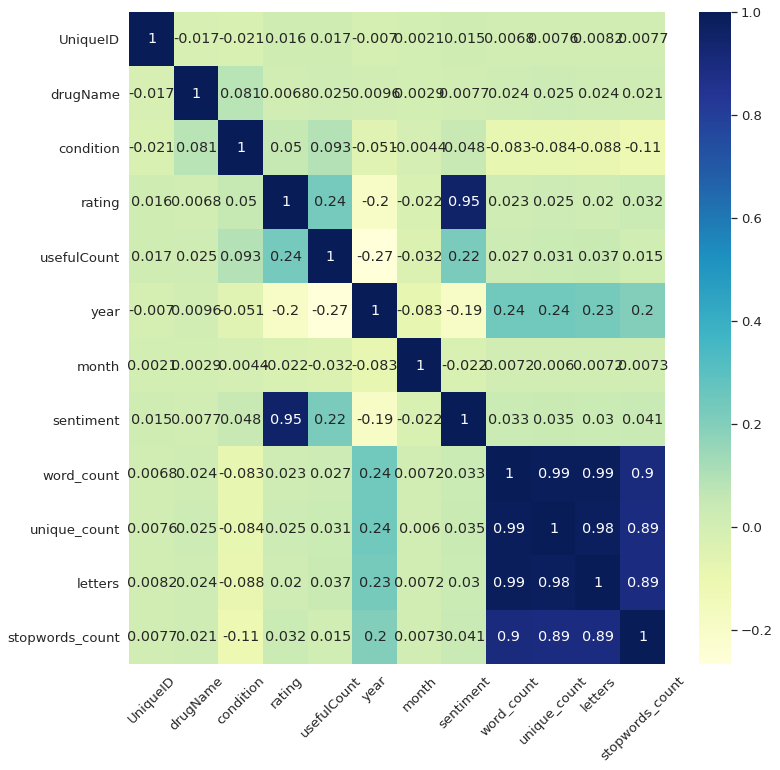

In [57]:
plt.rcParams['figure.figsize'] = [12,12]
sns.set(font_scale = 1.2)
corr = df.select_dtypes(include = 'int64').corr()
sns_corr = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(sns_corr.get_xticklabels(), rotation = 45);

In [58]:
df.columns

Index(['UniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'year', 'month', 'sentiment', 'review_clean',
       'word_count', 'unique_count', 'letters', 'stopwords_count',
       'sentiment_rate', 'sentiment_rate_clean'],
      dtype='object')

In [59]:
df.to_csv('drive/MyDrive/r_data/lgbm.csv',index=False)

In [60]:
features = df[['drugName','condition', 'usefulCount', 'year','month','sentiment_rate_clean','word_count', 'unique_count', 'letters',
                   'stopwords_count']]

target = df['sentiment']


Splitting Data for training and testing and sample size

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (149708, 10)
The Test set size  (64161, 10)


###**Modeling**

###LGBM Classifier


In [65]:
# Training Model - I
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model = clf.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions))
print ("The confusion Matrix is ")
confusion_matrix(y_test, predictions)

The Accuracy of the model is :  0.7870357382210377
The confusion Matrix is 


array([[ 9846,   108,  6147],
       [ 1256,  1217,  3317],
       [ 2707,   129, 39434]])

In [67]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66     16101
           1       0.84      0.21      0.34      5790
           2       0.81      0.93      0.87     42270

    accuracy                           0.79     64161
   macro avg       0.79      0.58      0.62     64161
weighted avg       0.79      0.79      0.77     64161



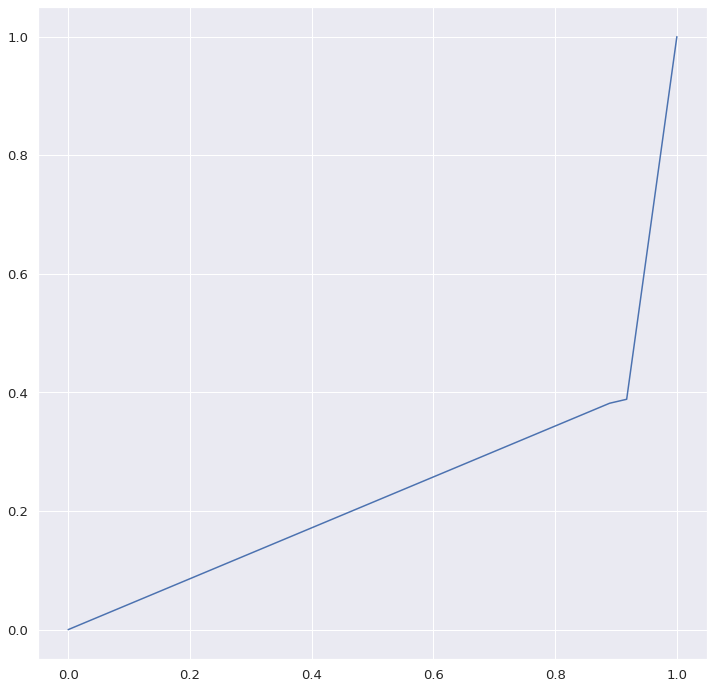

AUC: 0.23783511829702345
FPR: [0.         0.88953392 0.91754057 1.        ]
TPR: [0.         0.38177753 0.38848519 1.        ]


In [95]:
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [136]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(predictions))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


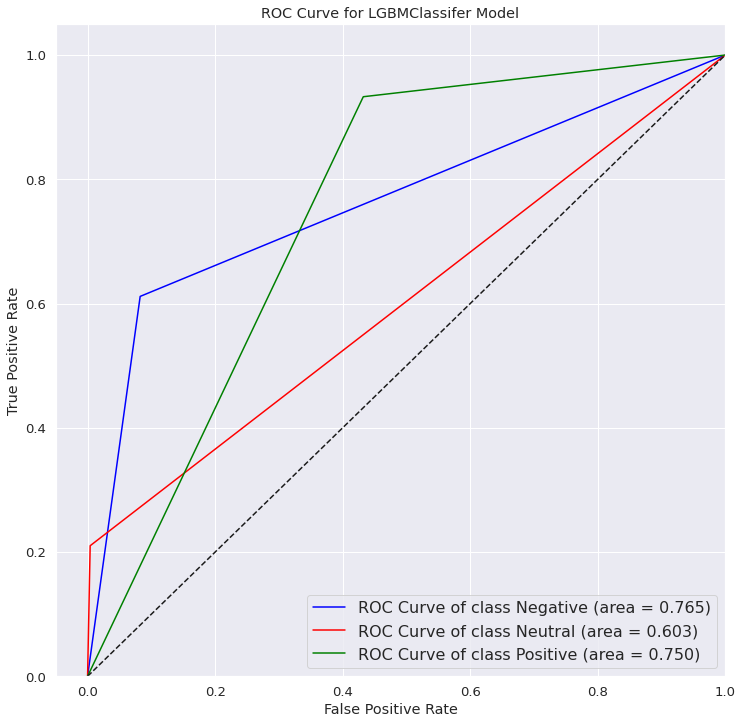

In [146]:
  colors = cycle(['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan'])
  for i, color, lbl in zip(range(n_classes), colors, ['Negative','Neutral','Positive']):
      plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
      label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for LGBMClassifer Model')
  plt.legend(loc = 'lower right', prop = {'size': 16})
  plt.savefig('roclgbm.png')
  plt.show()

###**Linear Regression Model**

In [3]:
data = pd.read_csv('drive/MyDrive/r_data/feature.csv')
data =data.dropna(how = 'any', axis = 0)
#data.sort_values(['UniqueID'], ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [5]:
features = data[['review_clean']]

target = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (149704, 1)
The Test set size  (64159, 1)


In [7]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.75, stop_words='english', lowercase=True)
x_train = vectorizer.fit_transform(X_train['review_clean'])
x_test = vectorizer.transform(X_test['review_clean'])

In [9]:
%%time
lr_clf = LogisticRegression(random_state =1, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
lr_clf.fit(x_train, y_train)
pred = lr_clf.predict(x_test)
score = accuracy_score(y_test, pred)
print('Accuracy is ', 100*score)

Accuracy is  71.72493336866222
CPU times: user 20.9 s, sys: 17.6 s, total: 38.5 s
Wall time: 19.6 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68     15944
           1       0.24      0.53      0.33      5686
           2       0.91      0.75      0.82     42529

    accuracy                           0.72     64159
   macro avg       0.61      0.66      0.61     64159
weighted avg       0.79      0.72      0.74     64159



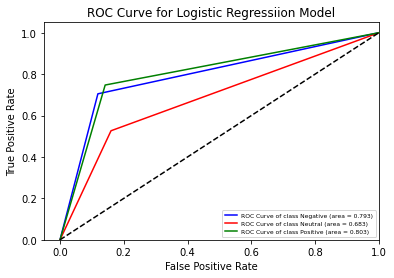

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan'])
for i, color, lbl in zip(range(n_classes), colors, ['Negative','Neutral','Positive']):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regressiion Model')
plt.legend(loc = 'lower right', prop = {'size': 6})
plt.savefig('roclgbm.png')
plt.show()

###**Random Forest Classifier**

In [17]:
%%time

clf = RandomForestClassifier() # class_weight='balanced'
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
score = accuracy_score(y_test, pred)
print('Accuracy is ', 100*score)

Accuracy is  88.14195981857573
CPU times: user 10min 44s, sys: 567 ms, total: 10min 44s
Wall time: 10min 44s


In [18]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     15944
           1       1.00      0.55      0.71      5686
           2       0.86      0.99      0.92     42529

    accuracy                           0.88     64159
   macro avg       0.93      0.75      0.81     64159
weighted avg       0.89      0.88      0.87     64159



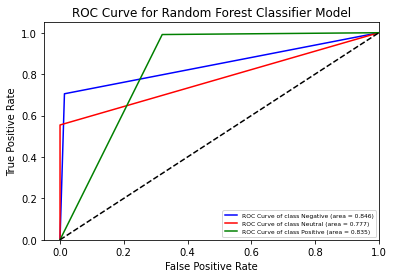

In [19]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan'])
for i, color, lbl in zip(range(n_classes), colors, ['Negative','Neutral','Positive']):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier Model')
plt.legend(loc = 'lower right', prop = {'size': 6})
plt.savefig('roclgbm.png')
plt.show()